# Figure : Variance Plots and Elbow Plots

In [1]:
# Import Python modules
import os, sys
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.colors import ListedColormap
from matplotlib import rcParams
# plot styles/formatting
import seaborn as sns

from IPython.display import Image, display
from sklearn.metrics import silhouette_score, silhouette_samples
# Path to modules
sys.path.append('../modules')
# Import my modules
from eofs import *
from kmeans import *

In [2]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/AR_types/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/AR_types/figs/'      # figures


In [3]:
# Set default font for all plots
rcParams['font.family'] = 'sans-serif'   # set the default font family to 'sans-serif'
rcParams['font.sans-serif'] = 'Arial'    # set the default sans-serif font to 'Arial'


### Calculate Explained Variance

In [9]:
ceofid = 'HUV500'
neofs = 2 # choose number of eofs
nk = 3 # choose number of clusters

# can add 'djf' and/or 'mam'
ssn_lst = ['djfmam']

In [10]:
err_lst = []
neofs_lst = []
pctvar_lst = []
n_events = [205., 237.]

for k, ssn in enumerate(ssn_lst):   
    ## Eigenvalues
    filepath =  path_to_out + ceofid + '/' + ssn + '/' + 'eigenvalues_tcor.txt'
    df = pd.read_csv(filepath, header=None, names=['evals'])
    evals = df.evals.values
    # Calculate the percent explained var by each eigenvector
    pctvar = pct_variance(evals)
    # Number of EOFs that explain more than 1% of the total variance
    idx = pctvar[pctvar >= 1.0]
    neof = len(idx)

    # North Test
    total_events = n_events[k]
    err = north_test(evals, total_events)
    
    err_lst.append(err)
    neofs_lst.append(neof)
    pctvar_lst.append(pctvar)
    

### Calculate Elbow & Silhouette Scores

In [11]:
# Loadings & AR CAT
kclusters_lst = []
cohesion_lst = []
silhouette_lst = []
lower_lst = []
upper_lst = []

for i, ssn in enumerate(ssn_lst):
    filename = path_to_out + ceofid + '/' + ssn + '/' + 'loadings_tcor.csv'
    df = pd.read_csv(filename)
    df = df.rename(columns={'Unnamed: 0': 'date'})
    df = df.set_index(pd.to_datetime(df.date))
    df = df.drop(columns=['date'])
    xdata = df.values
    
    # Determine optimal K
    # maximum number of clusters (number of iterations)
    kmax =15
    kclusters, cohesion, silhouette, lower, upper = plot_optimal_k(xdata, neofs, kmax, create_plot=False)
    kclusters_lst.append(kclusters)
    cohesion_lst.append(cohesion)
    silhouette_lst.append(silhouette)
    lower_lst.append(lower)
    upper_lst.append(upper)

### Load EOF values for KDE plots

In [13]:
# Loadings & AR CAT
df_lst = []
for i, ssn in enumerate(ssn_lst):
    out_path = path_to_out + ceofid + '/' + ssn + '/' + 'neof' + str(neofs) + '/k' + str(nk) + '/'
    df = pd.read_csv(out_path + 'AR-types-loadings.csv')
    # set up datetime index
    df = df.rename(columns={'Unnamed: 0': 'date'})
#     df = df.set_index(pd.to_datetime(df.date))
    df = df.drop(columns=['date'])
    df_lst.append(df)
    
df_lst[0].head()

,EOF1,EOF2,AR_CAT
0,0.659732,0.100230,3
1,0.359403,-0.043859,3
2,0.314731,0.238685,3
3,0.083094,-0.249722,2
4,-0.159718,0.111888,1


### Create Plot

/home/nash/DATA/repositories/AR_types/figs/fig4_variance_elbow_kde.png


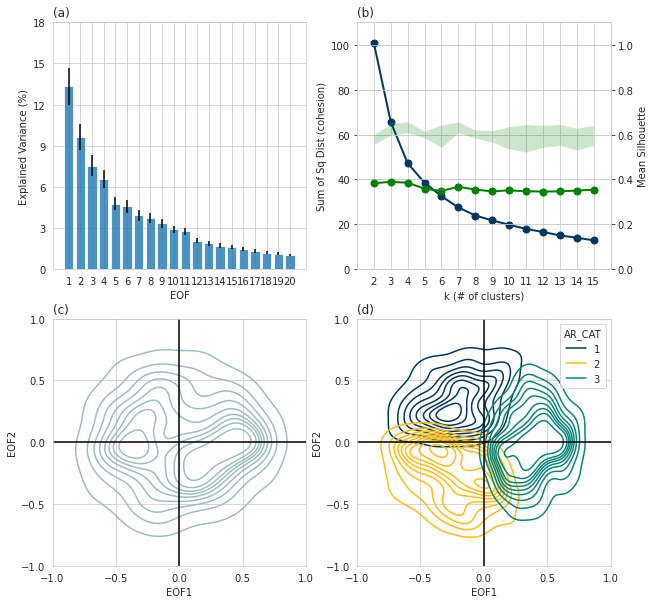

<Figure size 720x720 with 0 Axes>

In [16]:
# Create figure
fig = plt.figure(figsize=(10,10))
fname = path_to_figs + 'fig4_variance_elbow_kde'
fmt = 'png'
nrows = 2
ncols = 2
nplots=nrows*ncols
plt_lbl1 = ['(a)', '(b)']
plt_lbl2 = ['(c)', '(d)']

# Set custom color palette
colors = ["#003660"]
sns.set_palette(sns.color_palette(colors))
sns.set_style("whitegrid")

# Variance Plots
k=0
ax = fig.add_subplot(nrows, ncols, 1)
neofs = neofs_lst[k]
pctvar = pctvar_lst[k]
err = err_lst[k]
# plot data
xvals = np.arange(neofs) + 1
ax.bar(xvals, pctvar[0:neofs], yerr=err[0:neofs], 
       color='tab:blue', alpha=0.8)

# x-axis
ax.set_xlabel('EOF')
ax.set_xticks(xvals)

# y-axis
ax.set_ylabel('Explained Variance (%)')
ax.set_yticks(np.arange(0, 21, 3))

ax.set_title('(a)', loc='left')

# Elbow Plots

ax = fig.add_subplot(nrows, ncols, 2)
kclusters = kclusters_lst[k]
coh = cohesion_lst[k][0]
ax.plot(kclusters, coh, marker='o', linewidth=2.0, markersize=7.0)
ax.set_ylabel('Sum of Sq Dist (cohesion)')
ax.set_xlabel('k (# of clusters)')
ax.set_xticks(kclusters)
#     ax.set_yticks(np.arange(0, 110, 20))
ax.set_xlim(1., kmax+1)
ax.set_ylim(0, 110)
ax.set_xticks(kclusters)
ax.set_title('(b)', loc='left')

ax2 = ax.twinx()
sil = silhouette_lst[k][0]
lower = lower_lst[k][0]
upper = upper_lst[k][0]
ax2.plot(kclusters, sil, c='g', marker='o', linewidth=2.0, markersize=7.0)
ax2.fill_between(kclusters, lower, upper, fc='g', ec=None, alpha=0.2)
ax2.set_ylabel('Mean Silhouette')
ax2.set_xlabel('k (# of clusters)')
ax2.set_xlim(1., kmax+1)
ax2.set_ylim(0, 1.1)
ax2.set_xticks(kclusters)

## KDE Plots
# Set custom color palette
colors = ["#9CBEBE", "#047C91"] # mist, aqua
sns.set_palette(sns.color_palette(colors))
ax = fig.add_subplot(nrows, ncols, 3)
df = df_lst[k]
g = sns.kdeplot(data=df, x="EOF1", y="EOF2", fill=False, ax = ax)
ax.set_title(plt_lbl1[k], loc='left')
ax.set_xticks(np.arange(-1.0, 1.5, 0.5))
ax.set_yticks(np.arange(-1.0, 1.5, 0.5))
ax.set_ylim(-1.0, 1.0)
ax.set_xlim(-1.0, 1.0)
ax.axhline(0, color='k')
ax.axvline(0, color='k')
ax.set_title('(c)', loc='left')

ax = fig.add_subplot(nrows, ncols, 4)
colors = ["#003660", "#FEBC11", "#09847A"] # navy, gold, sea green
g = sns.kdeplot(data=df, x="EOF1", y="EOF2", hue="AR_CAT",  fill=False, ax = ax, palette=sns.color_palette(colors))
ax.set_title(plt_lbl2[k], loc='left')
ax.set_xticks(np.arange(-1.0, 1.5, 0.5))
ax.set_yticks(np.arange(-1.0, 1.5, 0.5))
ax.axhline(0, color='k')
ax.axvline(0, color='k')
ax.set_ylim(-1.0, 1.0)
ax.set_xlim(-1.0, 1.0)
ax.set_title('(d)', loc='left')


# Save the figure
fig.savefig('%s.%s' % (fname, fmt), bbox_inches='tight', dpi=fig.dpi)
fig.clf()

plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))

In [ ]:
## test different clusters for categorized kde